In [1]:
import numpy as np
import gpkit
import astropy.constants as const
import matplotlib.pyplot as plt
from gpkit import Model, Variable
from gpkit.nomials.math import SingleSignomialEquality,SignomialInequality
from gpkit.constraints.bounded import Bounded
gpkit.SIGNOMIALS_ENABLED = True
from collections import OrderedDict

In [4]:
muval = 3.986005e14
alpha_1 = 0.1399851
gamma_1 = 0.464835

R = Variable("R", const.R_earth.value/1000, "km", "earth radius")
eta_A = Variable("\\eta_A", 0.29, "-", "solar panel efficiency")
Q = Variable("Q", 1367, "W/m^2", "solar flux constant")
EN = Variable("EN", 40, "-", "ebno required")
D_r = Variable("D_r", 5.3, "m", "ground receive diamater")
G_r = Variable("G_r", "-", "ground receive gain")
L = Variable("L", 9.772372209558107, "-", "line loss") #1.58489
k = Variable("k", const.k_B.value, "J/K", "Boltzman constant R/Na")
T_s = Variable("T_s", 135, "K", "system temperature")
B = Variable("B", 8, "bit", "bit per pixel")
N = Variable("N", 2000, '-', 'number of pixels along width')
eta = Variable("\\eta", 0.55, "-", "dish efficiency")
lambda_v = Variable("\\lambda_{v}", 500, "nm", "image payload wavelength")
f = Variable("f", 2.2, "GHz", "transmit frequency")
c = Variable("c", const.c.value, "m/s", "Speed of light in vacuum")
lambda_c = Variable("\\lambda_{c}", "m", "transmit wavelength") #fake variable    

rho_A = Variable("\\rho_A", 10, "kg/m^2", "solar panel area density")
rho_p = Variable("\\rho_p", 100, "kg/m^1.5")
rho_T = Variable("\\rho_T", 2, "kg/m^1.5")
rho_P = Variable("\\rho_P", 500, "kg*km", 'propellant altitude constant')
rho_b = Variable("\\rho_b", 0.1, "kg/kJ")

P_l = Variable("P_{l}", 5, "W", "constant power drain")

X_r = Variable('X_r', 20, 'm', 'required resolution')
m_c = Variable("m_c", 0.2, "kg", "constant mass")
eta_S = Variable("\\eta_S", 0.2, "-", "structural mass percentage")

mu = Variable("mu", muval, "m^3/s^2", "standard gravitational parameter")

####
D_p = Variable("D_p", "m", "aperture")
D_T = Variable("D_T", "m", "spacecraft antenna diameter")
A = Variable("A", "m^2", "surface area solar panels")

m_t = Variable("m_t", 'kg', 'spacecraft total mass')
m_b = Variable("m_b", 'kg', 'battery mass')
m_A = Variable("m_A", 'kg', 'solar panel mass')
m_p = Variable("m_p", 'kg', 'payload mass')
m_T = Variable("m_T", 'kg', 'transmission mass')
m_S = Variable("m_S", 'kg', 'structural mass')
m_P = Variable("m_P", 'kg', 'propulsion mass')

P_t = Variable("P_t", "W", "total power")
P_A = Variable("P_A", "W", "solar panel power")
P_T = Variable("P_T", "W", "transmit power")
E_b = Variable("E_b", "J", "battery energy")

h = Variable("h", "km", "orbit altitude")
a = Variable("a", "km", "orbit semi-major axis")
r = Variable("r", "km", "max distance to ground station")
T = Variable("T", "min", "period")
d = Variable("d", "-", "not in-eclipse orbit fraction")
e = Variable("e", "-", "in-eclipse orbit fraction")
g = Variable("g", "-", "downlink orbit fraction")

constraints = [
    lambda_c == c/f,
    G_r == eta*(np.pi*D_r/lambda_c)**2,
    P_A == A*eta_A*Q,
    P_A == P_t/d, 
    P_T + P_l <= P_t,
    E_b >= P_A*e*T,
    EN == P_T*G_r*X_r*g*T*eta*D_T**2/(L*k*T_s*R*2*np.pi*N*B*(4*r**2)),
    X_r == h*lambda_v/D_p,
    e >= 1-d,
    d <= g + 0.5,
    a >= R+h,
    g == alpha_1*(h/R)**gamma_1,
    #g**0.133355 <= 0.295066*(h/R)**0.0619879+0.294791*(h/R)**0.061991+
    #0.294739 * (h/R)**0.0619928,
    T == 2*np.pi*(a**3/mu)**0.5,
    r**2 >= h**2 + 2*R*h,
    m_b == rho_b*E_b,
    m_p == rho_p*D_p**1.5,
    m_A == rho_A*A,
    m_T == rho_T*D_T**1.5,
    m_P == rho_P/h,
    m_S == eta_S*m_t,
    m_b+m_p+m_A+m_T+m_P+m_S+m_c <= m_t
]

In [5]:
m = Model(m_t, Bounded(constraints))
#m.substitutions.update({'Xp_{req}':('sweep', np.linspace(5, 50,50))})
sol = m.localsolve()

Beginning signomial solve.
Solving took 5 GP solves and 0.722 seconds.


In [6]:
print(sol.table())


Cost
----
 7.079 [kg] 

Free Variables
--------------
          A : 0.02987   [m**2] surface area solar panels
        D_T : 0.6502    [m]    spacecraft antenna diameter
        D_p : 0.01592   [m]    aperture
        E_b : 3.13e+04  [J]    battery energy
        G_r : 8211             ground receive gain
        P_A : 11.84     [W]    solar panel power
        P_T : 1.488     [W]    transmit power
        P_t : 6.488     [W]    total power
          T : 97.45     [min]  period
\lambda_{c} : 0.1363    [m]    transmit wavelength
          a : 7015      [km]   orbit semi-major axis
          d : 0.548            not in-eclipse orbit fraction
          e : 0.452            in-eclipse orbit fraction
          g : 0.04796          downlink orbit fraction
          h : 636.8     [km]   orbit altitude
        m_A : 0.2987    [kg]   solar panel mass
        m_P : 0.7852    [kg]   propulsion mass
        m_S : 1.416     [kg]   structural mass
        m_T : 1.048     [kg]   transmission mass
  

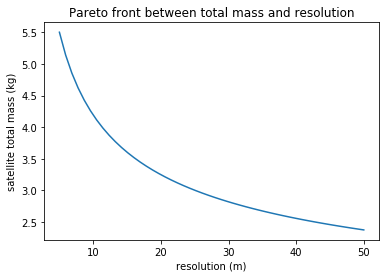

In [25]:
plt.plot(sol["variables"]["Xp_{req}"], sol["variables"]["m_{total}"])
plt.xlabel('resolution (m)')
plt.ylabel('satellite total mass (kg)')
plt.title('Pareto front between total mass and resolution')
plt.show()